In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np


In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [19]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')
    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)

In [20]:
def set_and_evaluate_alg(X_train, X_test, y_train, y_test, n_trees, max_depth, eta = 1):
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    return evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)

In [15]:
def iterate_n_trees(X_train, X_test, y_train, y_test, start_n_trees,  stop_n_trees, max_depth, eta, step_n_trees = 1):
    n_trees = []
    mse_tests = []
    mse_trains = []
    for n_tree in range(start_n_trees, stop_n_trees, step_n_trees):
        print(n_tree)
        mse_train, mse_test = set_and_evaluate_alg(X_train, X_test, y_train, y_test, n_tree, max_depth, eta)
        mse_trains.append(mse_train)
        mse_tests.append(mse_test)
        n_trees.append(n_tree)
    return n_trees, mse_trains, mse_tests

In [53]:
def iterate_max_depths(X_train, X_test, y_train, y_test, start_max_depths,  stop_max_depths, n_tree, eta, step_max_depths = 1):
    max_depths = []
    mse_tests = []
    mse_trains = []
    for max_depth in range(start_max_depths, stop_max_depths, step_max_depths):        
        print(max_depth)
        mse_train, mse_test = set_and_evaluate_alg(X_train, X_test, y_train, y_test, n_tree, max_depth, eta)
        mse_trains.append(mse_train)
        mse_tests.append(mse_test)
        max_depths.append(max_depth)
    return max_depths, mse_trains, mse_tests

In [57]:
n_trees, mse_trains, mse_tests = iterate_n_trees(X_train, X_test, y_train, y_test, start_n_trees = 5,  stop_n_trees = 50, max_depth = 5, eta = 1, step_n_trees = 5)

5
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 420.8380678821685
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 1 на тестовой выборке: 4884.71017844528
10
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 115.57651075685904
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тестовой выборке: 4899.115180694547
15
Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 24.720882522470298
Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 1 на тестовой выборке: 5261.282830027574
20
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 5.558028338905026
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 1 на тестовой выборке: 5401.336997461661
25
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 1.3611203776581837
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тестовой выборке: 5413.271008561529
3

In [23]:
import matplotlib.pyplot as plt

In [60]:
def get_error_plot(x_dots, train_err, test_err, xlabel, xlim_delta=30):
    plt.xlabel(xlabel)
    plt.ylabel('MSE')
    plt.xlim(0, x_dots[-1]+xlim_delta)
    
    plt.plot(x_dots, train_err, label='train error')
    plt.plot(x_dots, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()
    

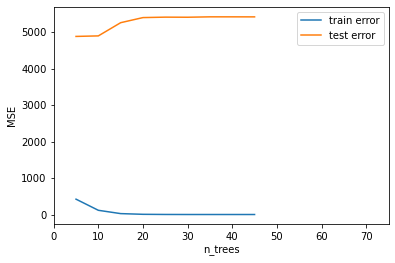

In [61]:
get_error_plot(n_trees, mse_trains, mse_tests, 'n_trees')

In [54]:
max_depths, mse_trains_md, mse_tests_md = iterate_max_depths(X_train, X_test, y_train, y_test, start_max_depths = 3,  stop_max_depths = 15, n_tree = 25, eta = 1, step_max_depths = 1)

3
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 306.5272679694674
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6955.330415026244
4
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 1 на тренировочной выборке: 71.37808121369922
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 1 на тестовой выборке: 7072.491896777587
5
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 1.3611203776581837
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тестовой выборке: 5413.271008561529
6
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 1 на тренировочной выборке: 0.01531360438746997
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 1 на тестовой выборке: 6203.142820561852
7
Ошибка алгоритма из 25 деревьев глубиной 7     с шагом 1 на тренировочной выборке: 1.4586517006003846e-05
Ошибка алгоритма из 25 деревьев глубиной 7     с шагом 1 на тестовой выборке: 5942.6442883210

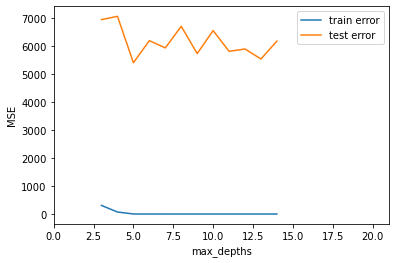

In [64]:
get_error_plot(max_depths, mse_trains_md, mse_tests_md, 'max_depths', xlim_delta = 7)

In [52]:
#Выводы - с ростом числа деревьев растет MSE на тесте, выходя затем на плато. 
#С ростом максимальной глубины величина MSE на тесте колеблется вверх-вниз, при этом наблюдается некоторый тренд на снижение.  


[]